# Data processing for the citation network exploration

## Nodes and Names matching 

This code script is used to conduct cross referencing between the BDWS dataset and the nodes to find matches. 
The node fils contains two columns, one with the id and one with the name. The women scientists file contains three columns with essentially the same content but in different format (lowercase, uppercase, title). 

The first output is a DF filtered_nodes containing the filtred nodes, which gives the ID, the name of the entity and the root with which they matched. 

In [1]:
import pandas as pd

# Load the nodes data
nodes_df = pd.read_csv('231116_nodes.csv')

# Load the name roots data
name_roots_df = pd.read_csv('all-names-processed.csv', delimiter=';')

# Extract the roots of the names for all three versions
name_roots = name_roots_df['names_lower'].tolist() + \
             name_roots_df['All_names'].tolist() + \
             name_roots_df['names_upper'].tolist()

# Function to filter and select specific nodes and mark matches with the matching root
def filter_nodes_by_name_roots(nodes_df, name_roots):
    
    # Initialize match and root columns with empty strings
    nodes_df['Match'] = ''
    nodes_df['Root'] = ''
    matching_persons = []

    for i, row in nodes_df.iterrows():
        name_parts = row['Name'].split()
        for part in name_parts:
            for root in name_roots:
                if part.startswith(root):
                    nodes_df.loc[i, 'Match'] = 'Match'
                    nodes_df.loc[i, 'Root'] = root
                    matching_persons.append({'id': row['id'], 'name': row['Name'], 'root': root})
                    break  # Break the inner loop to avoid multiple matches for the same part
    
    return nodes_df, pd.DataFrame(matching_persons)

# Filter persons with multiple name roots and select them for visualization
nodes_with_match_column_df, filtered_nodes_df = filter_nodes_by_name_roots(nodes_df, name_roots)

# Save the filtered nodes to a CSV file
filtered_nodes_df.to_csv('filtered_nodes.csv', index=False)

print("\nFiltered Nodes with Match and Root Columns:")
filtered_nodes_df


Filtered Nodes with Match and Root Columns:


,id,name,root
0,59,Kircherus,Kirch
1,298,Halleyus,Hall
2,351,Keill,Keil
3,493,Smith,Smith
4,502,Hallejus,Hall
...,...,...,...
242,58679,Gemmæ Frisii Medici,Medici
243,58841,Father Kircher,Kirch
244,59300,Extaticus Kircherus,Kirch
245,59345,F . Halley,Hall


In order to have an idea of the scope of the matches, I made a bar plot vizualizing the filtered_nodes. 

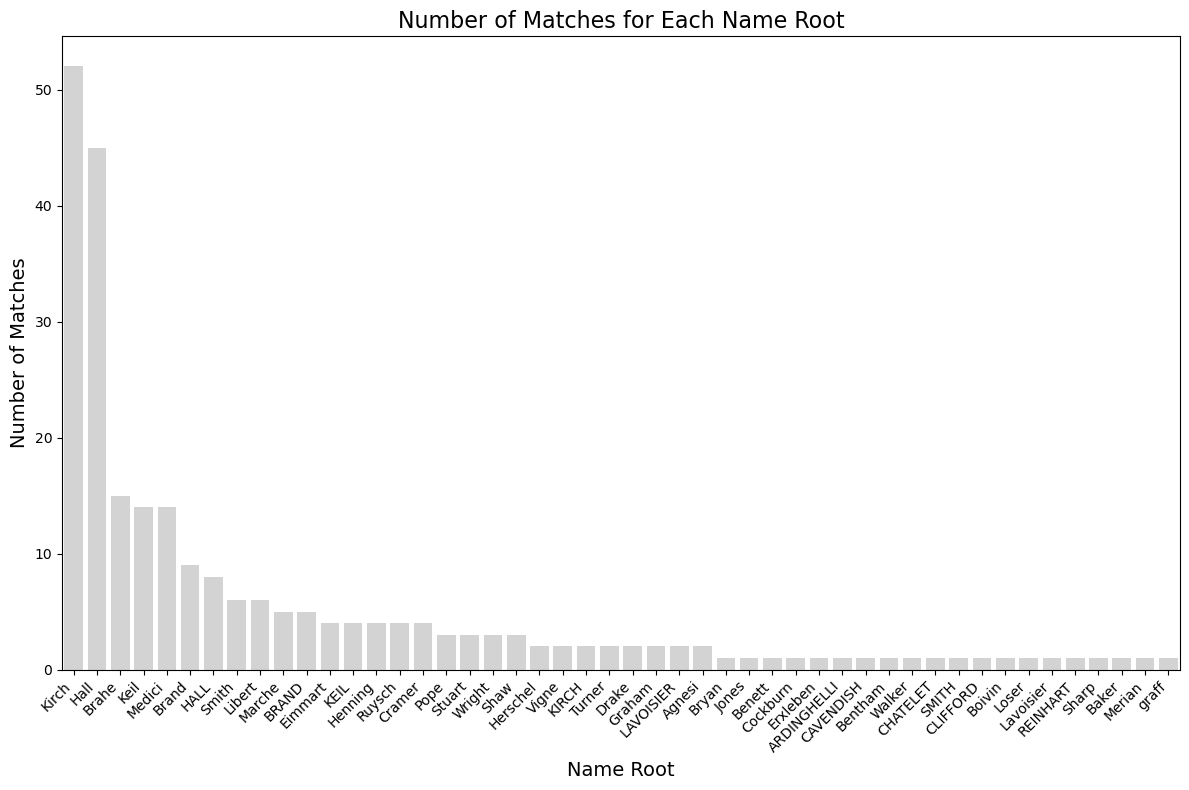

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the filtered nodes data
filtered_nodes_df = pd.read_csv('filtered_nodes.csv')

# Count the number of matches for each root
root_counts = filtered_nodes_df['root'].value_counts()

# Create a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=root_counts.index, y=root_counts.values, color="lightgray")
plt.xlabel('Name Root', fontsize=14)
plt.ylabel('Number of Matches', fontsize=14)
plt.title('Number of Matches for Each Name Root', fontsize=16)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

As explained in the dissertation, I did not find Laura Bassi in the first results, although I had found her in the network dataset files. This section aims to explore the filtered nodes dataset with both of her id in order verify if she is present in the filtered nodes file. We can see here that she is not. 

In [10]:
# Load the filtered nodes data
filtered_nodes_df = pd.read_csv('filtered_nodes.csv')

# Laura Bassi's 
specific_ids = [16844, 15712]

# Filter the DataFrame to include only rows with the specific IDs
specific_nodes_df = filtered_nodes_df[filtered_nodes_df['id'].isin(specific_ids)]

# Identify IDs that were not found
found_ids = specific_nodes_df['id'].tolist()
missing_ids = [id for id in specific_ids if id not in found_ids]

# Print results
if missing_ids:
    print(f"IDs not found in the filtered nodes DataFrame: {missing_ids}")
else:
    print("All specified IDs were found in the filtered nodes DataFrame.")

IDs not found in the filtered nodes DataFrame: [16844, 15712]


## Edges and Nodes: source and target matching

In [11]:
# Load the edges data
edges_df = pd.read_csv('231116_all_edges_above0_2.csv', sep=';')

# Load the filtered nodes data
filtered_nodes_df = pd.read_csv('filtered_nodes.csv')

# Check if the source or target IDs in the edges match any of the filtered nodes
edges_df['source_matched'] = edges_df['source'].isin(filtered_nodes_df['id'])
edges_df['target_matched'] = edges_df['target'].isin(filtered_nodes_df['id'])

# Create a new column to indicate if either the source or target ID matches
edges_df['visualization'] = edges_df.apply(
    lambda row: 'match' if row['source_matched'] or row['target_matched'] else '', axis=1
)

# Ensure IDs 16844 and 15712 (Laura Bassi), that were not found before are marked as "match"
edges_df.loc[(edges_df['source'].isin([16844, 15712])) | (edges_df['target'].isin([16844, 15712])), 'visualization'] = 'match'

# Optionally, drop the intermediate columns if only the 'visualization' column is needed
edges_df = edges_df.drop(columns=['source_matched', 'target_matched'])

# Calculate the number of matches (optional)
num_matches = (edges_df['visualization'] == 'match').sum()
print(f"Number of matches found: {num_matches}")

# Save the updated edges DataFrame to a new CSV file
edges_df.to_csv('updated_edges.csv', index=False)

Number of matches found: 1484


We now have an updated edges file which contains a added column named "vizualisation" which highlights the entities that are present either as source or target in the filtered nodes file. 

The next step is now to extract only the matches from this edges file, which will enable me to create a refined network as mentioned in the dissertation.

## Network extraction

In [6]:
# Load the edges data
edges_df = pd.read_csv('updated_edges.csv', delimiter=",")

# Filter edges to include only those marked as 'match'
filtered_edges_df = edges_df[(edges_df['visualization'] == 'match')]

# Extract unique nodes from the filtered edges
unique_node_ids = pd.unique(filtered_edges_df[['source', 'target']].values.ravel('K'))

# Load the all nodes data (assuming you have a file with all nodes data)
all_nodes_df = pd.read_csv('231116_nodes.csv')

# Filter nodes to include only those in the filtered edges
filtered_nodes_df = all_nodes_df[all_nodes_df['id'].isin(unique_node_ids)]

# Save the filtered edges to a new CSV file
filtered_edges_df.to_csv('extraction_filtered_edges.csv', index=False)

# Save the filtered nodes to a new CSV file
filtered_nodes_df.to_csv('extraction_filtered_nodes.csv', index=False)

In [7]:
# Print the filtered DataFrames to see them
print("\nFiltered Edges DataFrame:")
filtered_edges_df


Filtered Edges DataFrame:


,source,target,score,filename,entity_mention_clean,year,title,country,visualization
4055,60381,0,0.997385,DE Corpus/DE_Primary/1654_GRAFFT_CursusPhiloso...,Aristotelem,1654,CursusPhilosophiciThetikos,DE,match
11201,24032,0,0.992742,DE Corpus/DE_Secondary/1698_STUART_Thesesphysd...,Arist,1698,Thesesphysdererumnaturaliumprincipiis,DE,match
11202,24032,0,0.994020,DE Corpus/DE_Secondary/1698_STUART_Thesesphysd...,Arist,1698,Thesesphysdererumnaturaliumprincipiis,DE,match
11203,24032,0,0.994896,DE Corpus/DE_Secondary/1698_STUART_Thesesphysd...,Aristotelem,1698,Thesesphysdererumnaturaliumprincipiis,DE,match
11204,24032,0,0.985063,DE Corpus/DE_Secondary/1698_STUART_Thesesphysd...,ARISTOTELIS,1698,Thesesphysdererumnaturaliumprincipiis,DE,match
...,...,...,...,...,...,...,...,...,...
294532,351,100000,0.877067,UK Corpus/UK Primary/EN_Latin_PRIMARY_unlemmat...,Deum,1701,IntroductioAdVeramPhysicam.txt,UK,match
294533,351,100000,0.946940,UK Corpus/UK Primary/EN_Latin_PRIMARY_unlemmat...,Deum,1701,IntroductioAdVeramPhysicam.txt,UK,match
294534,351,100000,0.947320,UK Corpus/UK Primary/EN_Latin_PRIMARY_unlemmat...,Deum,1701,IntroductioAdVeramPhysicam.txt,UK,match
294535,351,100000,0.975417,UK Corpus/UK Primary/EN_Latin_PRIMARY_unlemmat...,Deus,1701,IntroductioAdVeramPhysicam.txt,UK,match


In [8]:
print("\nFiltered Nodes DataFrame:")
filtered_nodes_df


Filtered Nodes DataFrame:


,id,Name
0,0,Aristoteles/Arist (2)/Aristot(12)
1,1,Scotus
3,4,Christi
5,6,Platonis/Plato (7)
7,10,Cartesius / Cartesiani(31) / Cartesii (8)
...,...,...
60517,60525,nieuwland
60528,60536,abercromby
60531,60539,johnson
60532,60540,cleghorn


In [9]:
# Check for specific IDs in the source or target columns
specific_edges_df = filtered_edges_df[
    (filtered_edges_df['source'].isin([16844, 15712])) | 
    (filtered_edges_df['target'].isin([16844, 15712]))]

specific_edges_df

,source,target,score,filename,entity_mention_clean,year,title,country,visualization
207226,13471,15712,0.881867,NL Corpus/NL Primary/NL_Lat_PRIMARY_unlemmatiz...,LAURA BASSI comm . Bonon,1786,PositionesPhysicae.txt,NL,match
208076,479,16844,0.895436,FR Corpus/FR Secondary/FR_Latin_SECONDARY_unle...,Maria Catharina Bassi Journal,1755,PhysicaeRecentiorisOrigo,FR,match


Now, we have two extracted files, one for the relevant nodes and one for the relevant edges which will be used to vizualise the network in Gephi.